In [1]:
import pathlib

import demes
import demesdraw

from IPython.display import set_matplotlib_formats
from myst_nb import glue

set_matplotlib_formats("svg")
examples = pathlib.Path(".").parent.resolve() / ".." / "examples" / "tutorial"

def size_max(graph):
    return max(
        max(epoch.start_size, epoch.end_size)
        for deme in graph.demes
        for epoch in deme.epochs
    )

/tmp/ipykernel_2388/4004298998.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("svg")


(sec_tutorial)=

# Tutorial

## YAML

A Demes model is written as a [YAML](https://en.wikipedia.org/wiki/YAML) file.
A YAML file contains `property: value` pairs, and Demes imposes restrictions
by allowing only properties with specific names, which have specific types
of values.
YAML files have the extension `.yaml`, or sometimes `.yml`.
Don't worry if you've never heard of YAML before, as the details of YAML
aren't particularly important.
The example below gives an indication of what a Demes file looks like,
but we'll explain each component gradually using additional examples.
For now, select the "Drawing" tab to see a diagrammatic overview
of the demographic model.

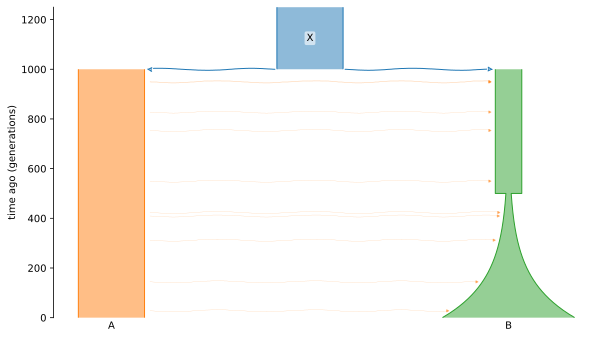

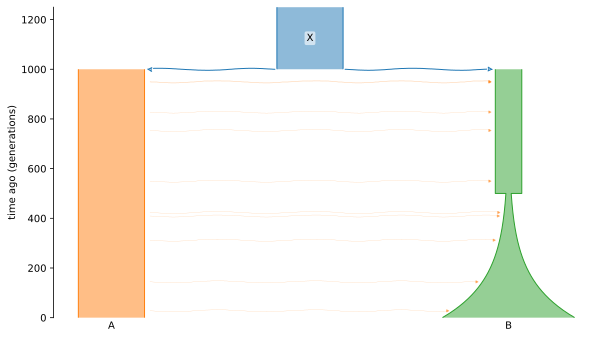

In [2]:
graph = demes.load(examples / "example_01.yaml")
w = 1.5 * size_max(graph)
positions = dict(X=0, A=-w, B=w)
ax = demesdraw.tubes(graph, positions=positions, seed=1)
glue("example_01", ax.figure, display=False)

{{ example.replace("LABEL", "01") }}

```{note}
The Demes specification defines a data model, not the YAML format itself.
A demographic model that uses the Demes data model can be easily converted
to any desired data-serialisation language.
```

## Terminology

We use the word "Demes" with a capital D to refer to the Demes data model or
the Demes specification, and "deme" or "demes" with a lowercase d when we
refer to a collection of individuals (a deme) or a property in the Demes
data model.

## What is a deme?

A deme is a collection of individuals that share a set of population
parameters at any given time. Consider the simplest population model:
a single deme with constant population size.

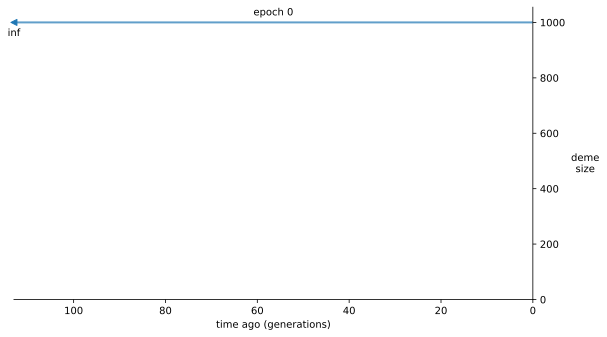

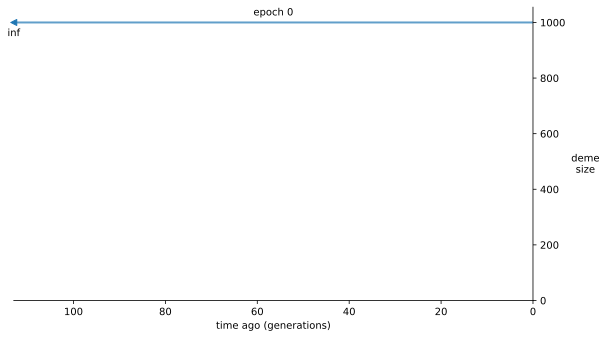

In [3]:
graph = demes.load(examples / "example_02.yaml")
ax = demesdraw.size_history(graph, inf_label=True, invert_x=True, annotate_epochs=True)
glue("example_02", ax.figure, display=False)

{{ example.replace("LABEL", "02").replace("%DRAWING_TAG", ":selected:") }}


This deme exists now (zero generations ago), and also exists as far back
in time as we're interested in looking (towards infinity generations ago).
In Demes, we say that the deme has an infinite `start_time`.
Select the "YAML" tab above the drawing to see how this model was implemented.

```{note}
In YAML, infinity is spelled `.inf`, not `inf`.
```

```{note}
Each Demes model must define at least one deme with an infinite `start_time`.
```

### Default values

Having a deme's `start_time` property be infinite is very common.
So for demes without ancestors, the `start_time` may be omitted,
and will default to `.inf`. Similarly, the `end_time` property of
the final epoch may be omitted, and will default to `0`.
The following Demes file describes an equivalent model.

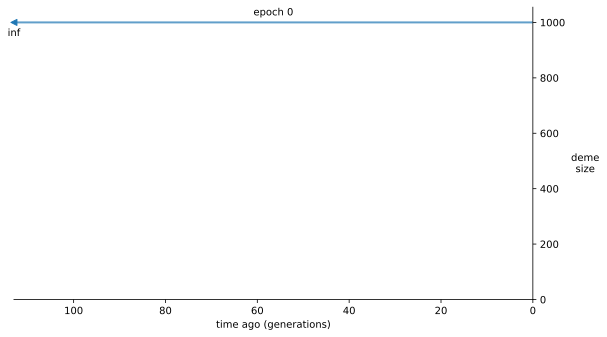

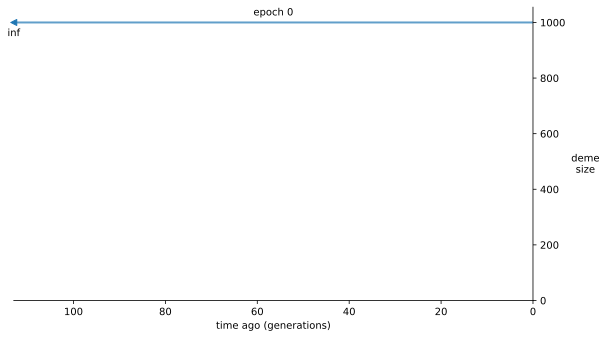

In [4]:
graph = demes.load(examples / "example_03.yaml")
ax = demesdraw.size_history(graph, inf_label=True, invert_x=True, annotate_epochs=True)
glue("example_03", ax.figure, display=False)

{{ example.replace("LABEL", "03") }}

## What is an epoch?

We partition a deme's interval of existence into distinct `epochs`.
A deme always has at least one epoch. The population parameters for a
deme are allowed to change over time, but are fixed within an epoch.
Consider a single deme that suffered a bottleneck 50 generations ago.

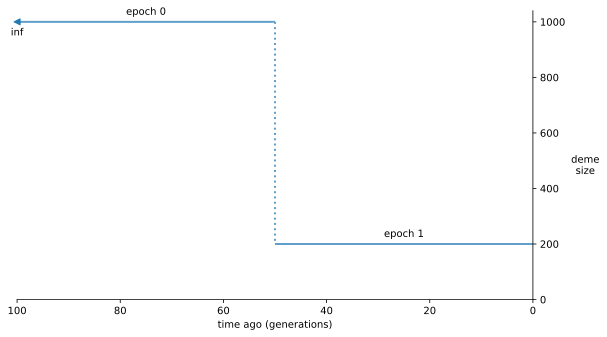

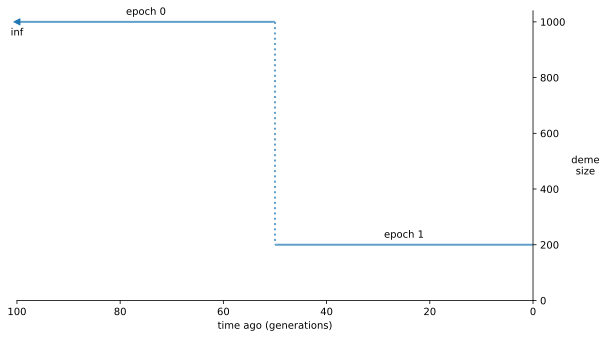

In [5]:
graph = demes.load(examples / "example_04.yaml")
ax = demesdraw.size_history(
    graph, inf_ratio=0.5, inf_label=True, invert_x=True, annotate_epochs=True
)
glue("example_04", ax.figure, display=False)

{{ example.replace("LABEL", "04").replace("%DRAWING_TAG", ":selected:") }}

To specify the change in the population size, we've introduced a second epoch
into the YAML file.
We now need three time values to define the epoch boundaries:
the `start_time` of the deme, the `end_time` of epoch 0,
and the `end_time` of epoch 1. All epochs must be listed in time-descending
order (from the past towards the present).

The same model can be written using default values for the deme's
`start_time` and the final epoch's `end_time`.

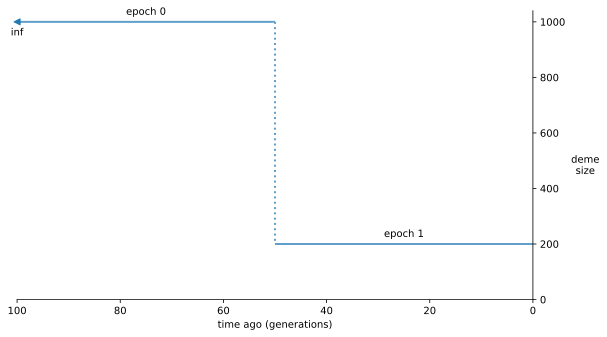

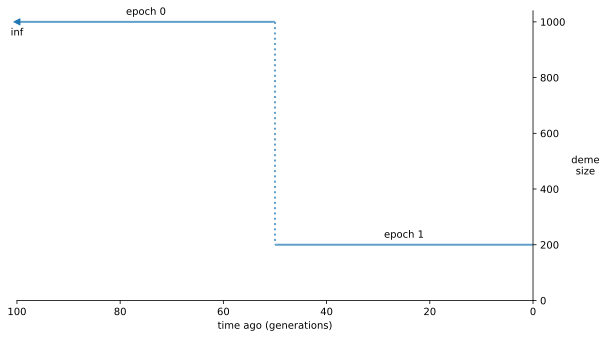

In [6]:
graph = demes.load(examples / "example_05.yaml")
ax = demesdraw.size_history(
    graph, inf_ratio=0.5, inf_label=True, invert_x=True, annotate_epochs=True
)
glue("example_05", ax.figure, display=False)

{{ example.replace("LABEL", "05") }}

### Why don't epochs have a `start_time` too?

The start time of an epoch can be inferred indirectly, by looking at the
deme's `start_time` (for epoch 0), or by looking at the previous epoch's
`end_time` (for epoch 1, 2, etc.).


## Exponential size changes

In the previous model, the population size was constant in each epoch.
But what if we wanted to model a period of exponential population size growth,
or an exponential decay? In any given epoch, there are actually two
population size parameters, `start_size` and `end_size`, which correspond
to the size at the start and end of the epoch. If both parameters have the
same value, then the size is constant over the epoch.
However, If an epoch's `start_size` and `end_size` properties are not equal,
then the epoch is defined to have an exponentially-changing population size
over the epoch's time interval. Two important implications of this system are:

* We don't need to specify a rate parameter for the exponential.
  If this really is needed, it can be calculated from the `start_size`,
  `end_size`, `start_time` and `end_time` values for an epoch.

* Infinitely long epochs must have a constant population size.
  So if a deme has an infinite `start_time`, then `start_size`
  and `end_size` must be equal for epoch 0.

To make these ideas more concrete, let's look at an implementation of
the well-known ZigZag model from
[Schiffels & Durbin (2014)](https://doi.org/10.1038/ng.3015).

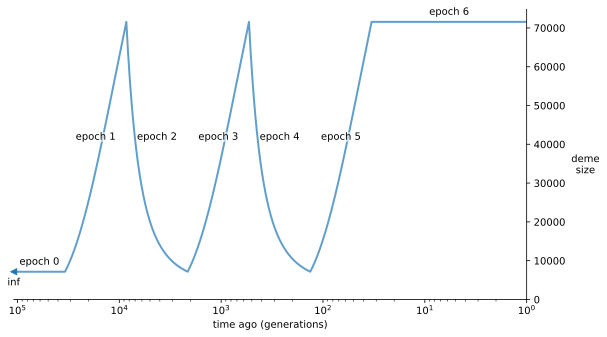

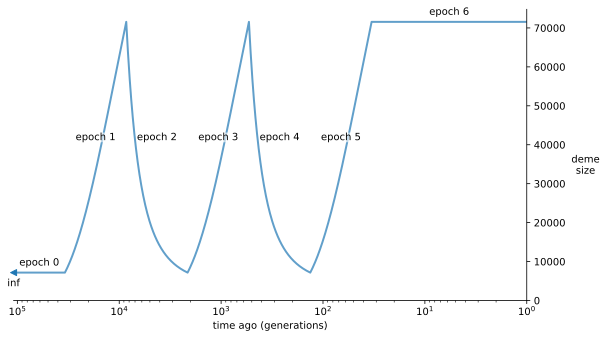

In [7]:
graph = demes.load(examples / "example_06.yaml")
ax = demesdraw.size_history(
    graph, inf_label=True, invert_x=True, annotate_epochs=True, log_time=True,
)
glue("example_06", ax.figure, display=False)

{{ example.replace("LABEL", "06") }}

We've introduced several new features to implement this model,
so let's step through it from top to bottom.

* The `doi` property is a list of strings corresponding to the DOI(s)
  for publication(s) in which the model was described. By convention,
  the elements of the `doi` list are URLs, but any string value can be used.

* A compact-form syntax is used for each epoch in the `epochs` list
  (with curly braces `{` and `}`), rather than using multiple lines.
  This is known as "flow style" in YAML parlance.

* Epoch 0 has a `start_size`, but no `end_size`. Because this epoch has
  an infinite time span, the population size must be constant, so the
  epoch's `end_size` will be the same as the `start_size`.

* Epoch 1 has an `end_size`, but no `start_size`. So the `start_size`
  is inherited from the `end_size` of the previous epoch.
  This means the `end_size` and `start_size` for this epoch are different,
  and there will be exponential population growth over the epoch.

* Epochs 2 through 5 also inherit their `start_size` from the previous
  epoch, and in each case these are different from the `end_size` provided.

* Epochs 2 and 4 have exponential decay, whereas epochs 3 and 5 have
  exponential growth.

* The final epoch has a constant size.


```{warning}
Other modelling frameworks may use the terms "epoch" or "epochs" to refer to
time intervals that partition an entire model. However, in Demes,
epochs are a deme-specific property, and each deme has its own list
of epochs which do not apply to the other demes in the model.
```

## Multiple demes

### A split event

Suppose we're interested in modelling two demes, `A` and `B`.
The two demes are related by a common ancestor, from which they split
1000 generations ago. In addition to `A` and `B`, we'll model their
common ancestor as an additional deme, `X`.
Here, we introduce the `ancestors` property of a deme,
which is a list of deme names.

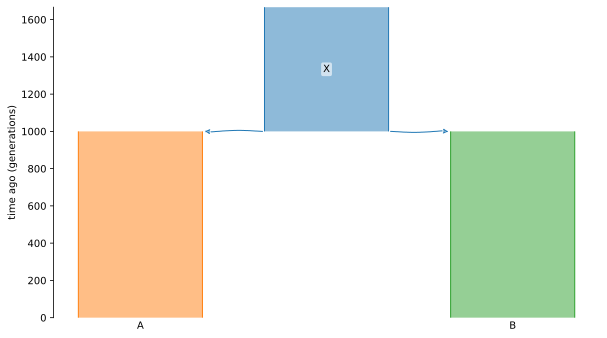

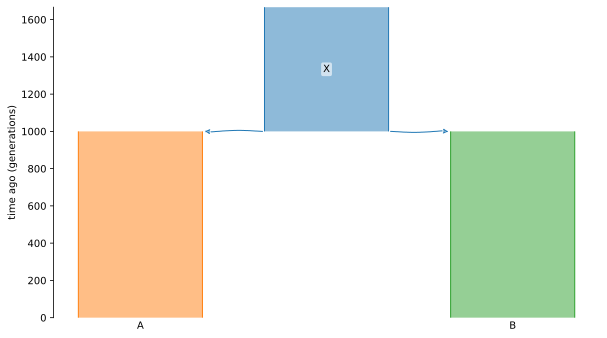

In [8]:
graph = demes.load(examples / "example_07.yaml")
w = 1.5 * size_max(graph)
positions = dict(X=0, A=-w, B=w)
ax = demesdraw.tubes(graph, positions=positions, seed=1, inf_ratio=0.4)
glue("example_07", ax.figure, display=False)

{{ example.replace("LABEL", "07") }}

When a deme has an ancestor, its `start_time` does **not** default to `.inf`.
In this case, the `start_time` for the deme is inherited from the
`end_time` of the ancestor.
I.e. for the model above, both `A` and `B` have a `start_time`
1000 generations ago.

```{note}
A deme cannot appear in the demes list before its ancestor(s).
This means models must be written in a "top down" manner,
starting with the ancestral (root) deme(s), and followed
by increasingly recent demes.
```

By convention, we use a more compact form for the ancestors list.
Lists can be written more compactly with YAML "flow style", which uses
square brackets (`[` and `]`, with a comma separating list items).
The following Demes file describes an equivalent model.

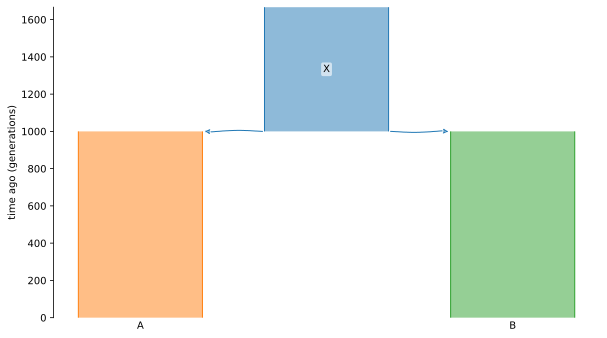

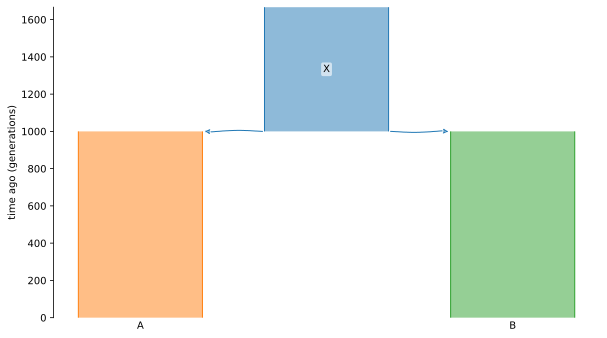

In [9]:
graph = demes.load(examples / "example_08.yaml")
w = 1.5 * size_max(graph)
positions = dict(X=0, A=-w, B=w)
ax = demesdraw.tubes(graph, positions=positions, seed=1, inf_ratio=0.4)
glue("example_08", ax.figure, display=False)

{{ example.replace("LABEL", "08") }}


### A branch event

An alternative way of modelling a population split is for the
ancestral deme to remain alive after the split. We will refer to this
as a *branch* event, rather than a split event.
In the model below, deme `A` has `X` as an ancestor like the previous model,
except here `X` continues to exist until 0 generations ago
(recall that 0 is the default value for the final epoch's `end_time`).
Now that `A`'s ancestor exists until 0 generations ago we must
explicitly provide a `start_time` for `A`.

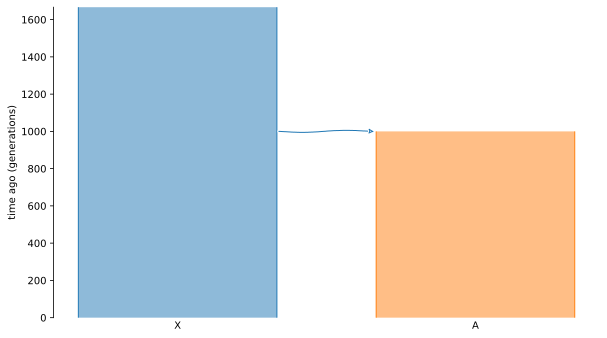

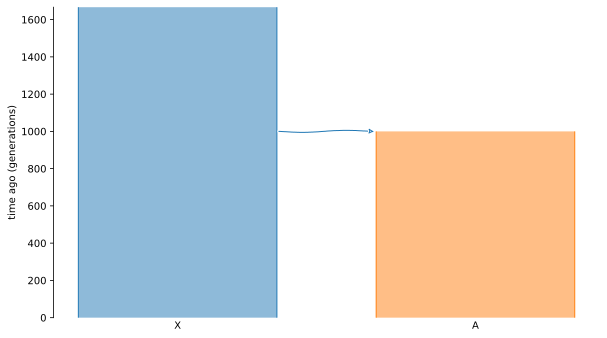

In [10]:
graph = demes.load(examples / "example_09.yaml")
w = 1.5 * size_max(graph)
positions = dict(X=0, A=w)
ax = demesdraw.tubes(graph, positions=positions, seed=1, inf_ratio=0.4)
glue("example_09", ax.figure, display=False)

{{ example.replace("LABEL", "09") }}

## Multiple ancestors

When a deme has multiple ancestors, these appear in the `ancestors` list
as one might expect. But for multiple ancestors we need to also specify the
proportion of ancestry inherited from each ancestor. This is done using
the deme's `proportions` list property. The first proportion in the
`proportions` list is for the first ancestor in the `ancestors` list,
the second proportion is for the second ancestor, and so on.
Just like the case of a single ancestor, an ancestor can terminate at
the descendant's `start_time`, or can instead continue to exist.

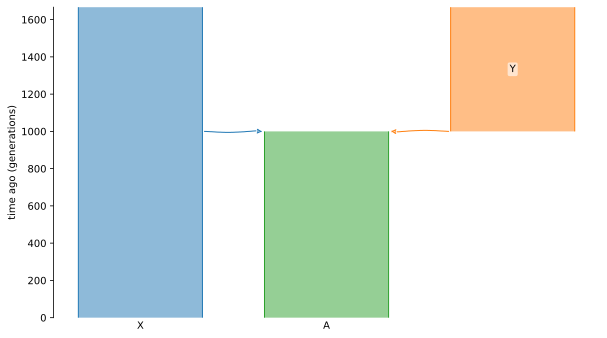

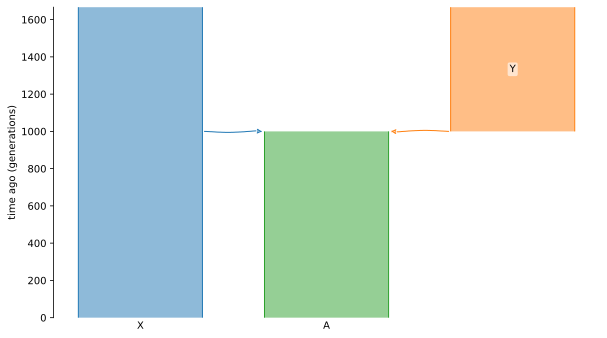

In [11]:
graph = demes.load(examples / "example_10.yaml")
w = 1.5 * size_max(graph)
positions = dict(X=-w, Y=w, A=0)
ax = demesdraw.tubes(graph, positions=positions, seed=1, inf_ratio=0.4)
glue("example_10", ax.figure, display=False)

{{ example.replace("LABEL", "10") }}

```{note}
With multiple ancestors, the `start_time` of the descendant deme does not
default to the `end_time` of any of its ancestors. So the `start_time`
must always be specified for a deme with multiple ancestors.
```


## Continuous migration

Let's again consider a model with demes `A` and `B`, which are related
via a common ancestor `X` (a split event).

### Asymmetric migration

To define continuous migration from `A` to `B`, we'll add an entry to the
`migrations` list.
Concretely, we are modelling migrants born in deme `A`, the `source` deme,
who (potentially) have offspring in deme `B`, the `dest` deme.

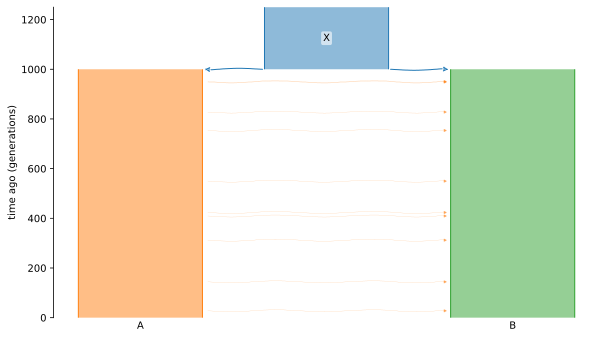

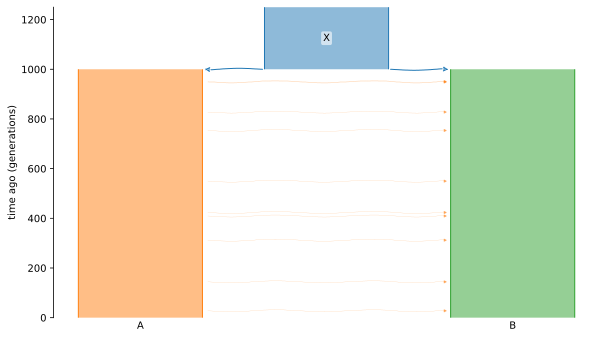

In [12]:
graph = demes.load(examples / "example_11.yaml")
w = 1.5 * size_max(graph)
positions = dict(X=0, A=-w, B=w)
ax = demesdraw.tubes(graph, positions=positions, seed=1)
glue("example_11", ax.figure, display=False)

{{ example.replace("LABEL", "11") }}

The migrations here occur at a `rate` of `1e-4` per generation,
and occur continuously over the lifetime of both `A` and `B`.

```{warning}
Migration rate units are always "per generation" regardless of
the chosen value for `time_units` (described later).
```

In the example above, `A` and `B` have identical existence time intervals.
If the `source` and `dest` demes do not have identical start
or end times, then by default the migration will occur over
the period of time when both demes exist simultaneously.

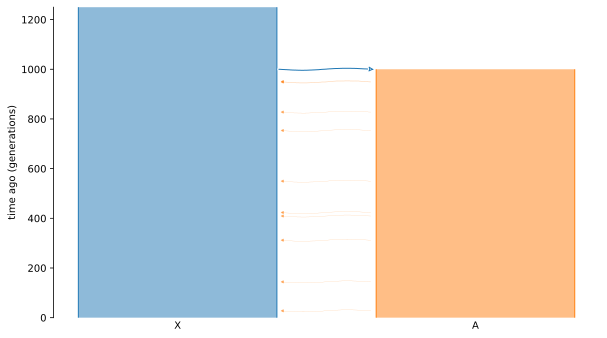

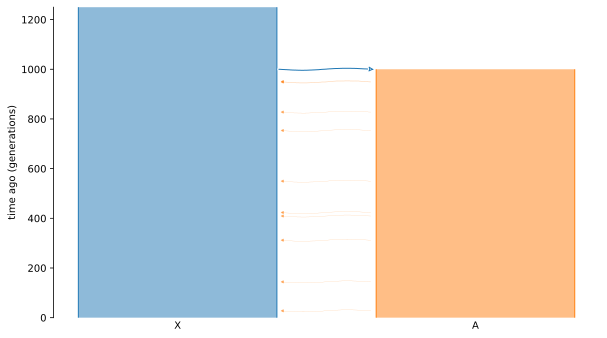

In [13]:
graph = demes.load(examples / "example_12.yaml")
w = 1.5 * size_max(graph)
positions = dict(X=0, A=w)
ax = demesdraw.tubes(graph, positions=positions, seed=1)
glue("example_12", ax.figure, display=False)

{{ example.replace("LABEL", "12") }}

To obtain greater control over when migrations occur,
we can use the `start_time` and `end_time` migration properties.
Below we model three periods of continuous migration.

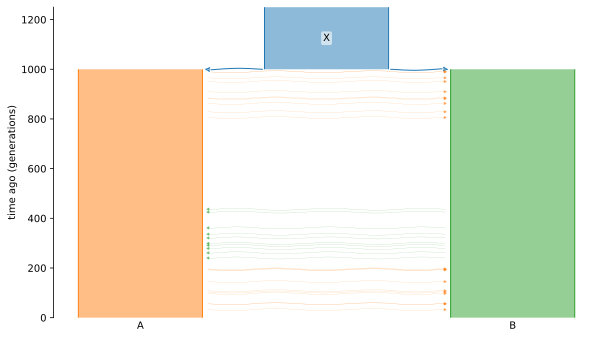

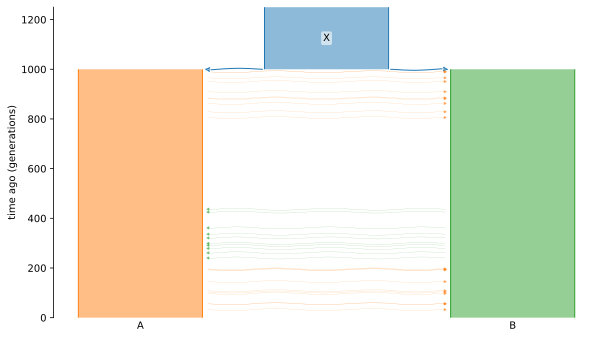

In [14]:
graph = demes.load(examples / "example_13.yaml")
w = 1.5 * size_max(graph)
positions = dict(X=0, A=-w, B=w)
ax = demesdraw.tubes(graph, positions=positions, seed=1)
glue("example_13", ax.figure, display=False)

{{ example.replace("LABEL", "13") }}

```{admonition} Question
:class: question
What do you think will happen if we list two or more migrations with
time intervals that overlap? Does it matter if the `source` and `dest`
demes are the same in each case?
```
```{admonition} Answer
:class: dropdown answer
Overlapping migrations are allowed in general.
But because it's not clear what the expected behaviour should be when
overlapping migrations are defined with the same `source` and `dest`,
it's an error to define such migrations.
```

### Symmetric migration

It's common to model migrants in both directions simultaneously,
with the same `rate`. We could use multiple asymmetric migrations,
but it's simpler to specify a list of deme names (the migration's
`demes` property), instead of a `source` and `dest`.

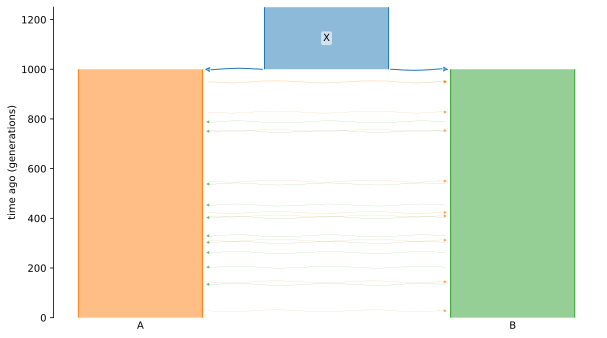

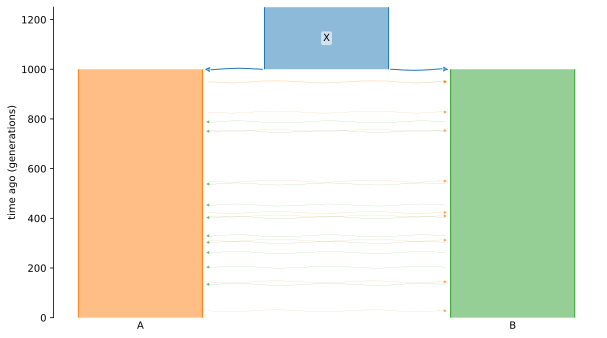

In [15]:
graph = demes.load(examples / "example_14.yaml")
w = 1.5 * size_max(graph)
positions = dict(X=0, A=-w, B=w)
ax = demesdraw.tubes(graph, positions=positions, seed=1)
glue("example_14", ax.figure, display=False)

{{ example.replace("LABEL", "14") }}

The `demes` property can list arbitrarily many demes. For example,
we could define symmetric migration between all pairwise combinations
of four demes.

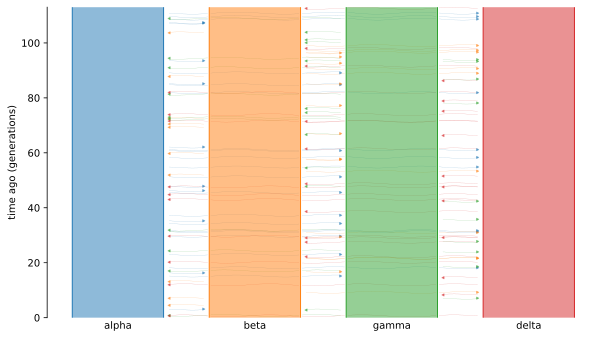

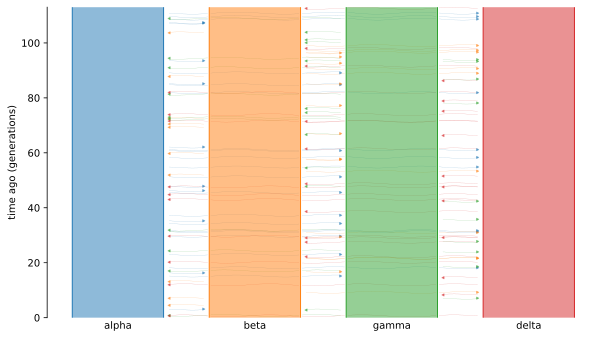

In [16]:
graph = demes.load(examples / "example_15.yaml")
w = 1.5 * size_max(graph)
positions = dict(alpha=0, beta=w, gamma=2 * w, delta=3 * w)
ax = demesdraw.tubes(graph, positions=positions, seed=1)
glue("example_15", ax.figure, display=False)

{{ example.replace("LABEL", "15") }}

When the following three conditions are satisfied:
* a symmetric migration is defined between more than two demes,
* and the demes' start and/or end times are not all identical,
* and the migration's `start_time` and/or `end_time` are omitted,

then the time intervals for the migration are resolved separately for
each pair of participating demes. E.g. for the model below, migration
between `A` and `B` occurs at all times because both `A` and `B`
exist for all time. However, migrations between `A` and `C`, and between
`B` and `C`, are limited to the period of time after 100 generations ago,
because `C` does not exist before then.

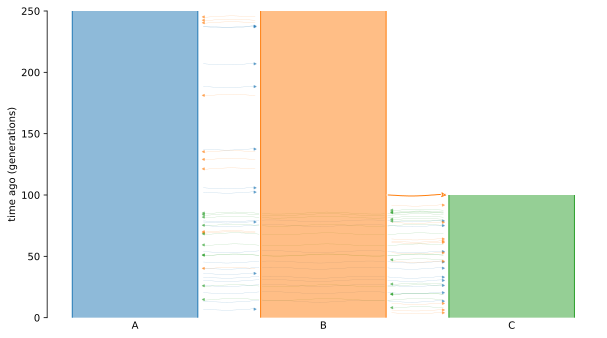

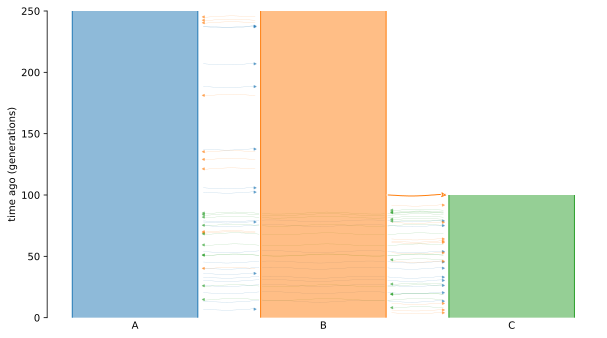

In [17]:
graph = demes.load(examples / "example_16.yaml")
w = 1.5 * size_max(graph)
positions = dict(A=0, B=w, C=2 * w)
ax = demesdraw.tubes(graph, positions=positions, inf_ratio=0.6, seed=1)
glue("example_16", ax.figure, display=False)

{{ example.replace("LABEL", "16") }}


## A pulse of admixture

To model migration that is limited to a very short period of time,
we can define one or more `pulses`.
A pulse has a `proportions` list property and a `sources` list property
(analogous to the `proportions` and `ancestors` properties of a `deme`).
Each pulse proportion defines the proportion of the `dest` deme that is
made up of ancestry from the corresponding source deme at the instant after
the pulse's `time`.

```{note}
The exact duration of a pulse is not defined by the Demes specification.
Software which implements a continuous-time model
(such as a coalescent simulator)
might treat a pulse as occurring instantaneously.
In contrast, software which implements a discrete-time model is free to treat
the pulse as occurring over a single time step (such as a single generation).
```

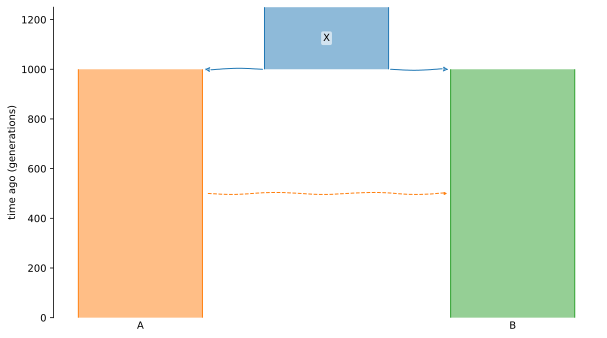

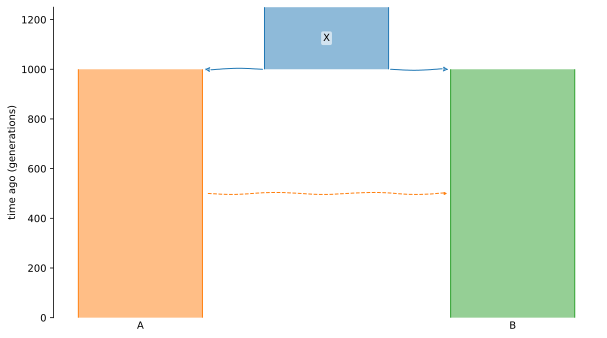

In [18]:
graph = demes.load(examples / "example_17.yaml")
w = 1.5 * size_max(graph)
positions = dict(X=0, A=-w, B=w)
ax = demesdraw.tubes(graph, positions=positions, seed=1)
glue("example_17", ax.figure, display=False)

{{ example.replace("LABEL", "17") }}


```{admonition} Excercise
:class: exercise
The `dest` deme in an admixture pulse could instead be modelled using
multiple ancestors.
Try doing this for deme `B` in the model above. What do you think are
the advantages of one approach over the other?
```

```{admonition} Question
:class: question
How should one interpret multiple pulses that occur at the same `time`?
Does it matter whether the `sources` and `dest` demes are the same in
each pulse?
```

````{admonition} Answer
:class: dropdown answer
When multiple pulses are specified with the same `time`,
the migration pulses occur in the order in which they are written.
Consider the following two pulses into deme `A` at time 100.

```yaml
pulses:
- sources: [B]
  dest: A
  time: 100
  proportions: [0.1]
- sources: [C]
  dest: A
  time: 100
  proportions: [0.2]
```

The second pulse replaces 20% of `A`'s ancestry, including 20% of the ancestry
that was inherited from `B` in the first pulse.
So immediately after time 100, `A` has 20% ancestry from `C` but only 8%
ancestry from `B`.
As this may be confusing, we recommend avoiding the use of multiple pulses
in this way, and instead implement the model using multiple `sources` with
the desired final ancestry `proportions`.

```yaml
pulses:
- sources: [B, C]
  dest: A
  time: 100
  proportions: [0.08, 0.2]
```

More complex models involving multiple simultaneous pulses are possible,
but we caution that they can be difficult to reason about.

````


(sec_tutorial_defaults)=

## Setting defaults

To avoid duplication in a Demes graph with many features, it's possible
to set default values for some properties. Suppose we wish to define
multiple demes, each with only one epoch, and each with a constant
population size.

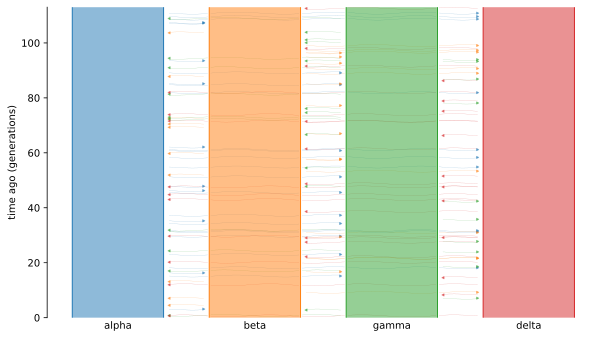

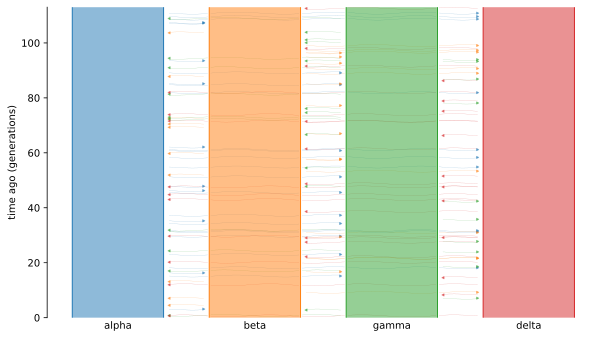

In [19]:
graph = demes.load(examples / "example_18.yaml")
w = 1.5 * size_max(graph)
positions = dict(alpha=0, beta=w, gamma=2 * w, delta=3 * w)
ax = demesdraw.tubes(graph, positions=positions, seed=1)
glue("example_18", ax.figure, display=False)

{{ example.replace("LABEL", "18") }}

The epoch defaults can be overridden by providing an explicit value inside
the desired epoch.

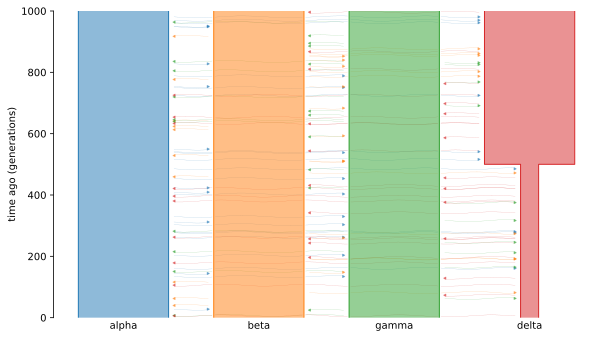

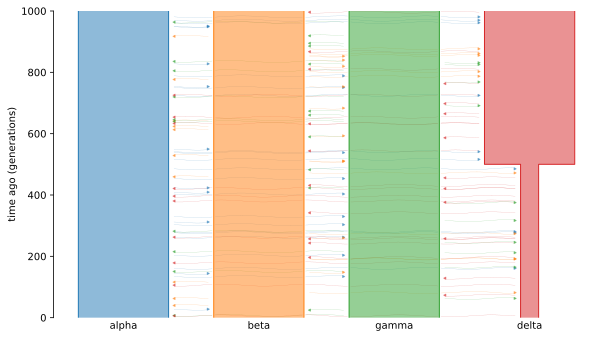

In [20]:
graph = demes.load(examples / "example_19.yaml")
w = 1.5 * size_max(graph)
positions = dict(alpha=0, beta=w, gamma=2 * w, delta=3 * w)
ax = demesdraw.tubes(graph, positions=positions, seed=1, inf_ratio=0.5)
glue("example_19", ax.figure, display=False)

{{ example.replace("LABEL", "19") }}

It's also possible to provide defaults for properties of a deme,
such as the `start_time` and `ancestors`.

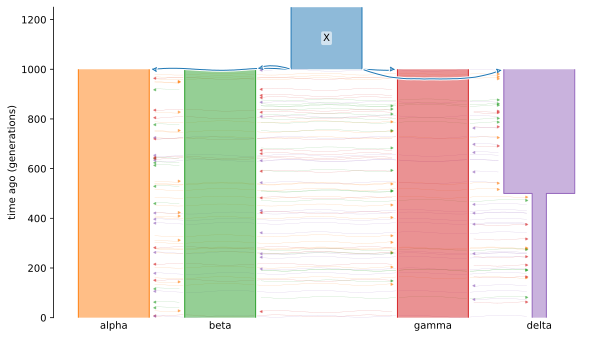

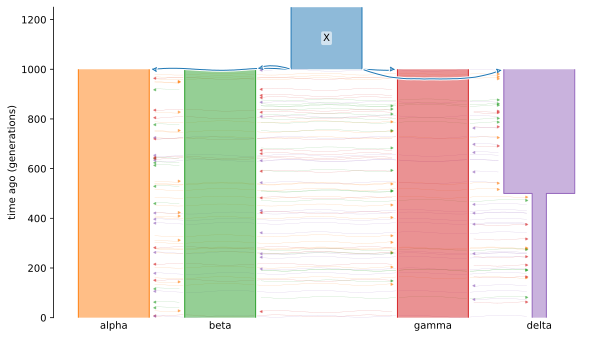

In [21]:
graph = demes.load(examples / "example_20.yaml")
w = 1.5 * size_max(graph)
positions = dict(alpha=-2 * w, beta=-w, X=0, gamma=w, delta=2 * w)
ax = demesdraw.tubes(graph, positions=positions, seed=1)
glue("example_20", ax.figure, display=False)

{{ example.replace("LABEL", "20") }}

```{admonition} Question
:class: question
How would the model be interpreted if we failed to override the `start_time`
and `ancestors` deme defaults for deme `X`?
```

```{admonition} Answer
:class: dropdown answer
If we didn't override the default `start_time`, then `X` would have
both a `start_time` and `end_time` of 1000. This would be invalid,
because (a) there would be no deme with an infinite `start_time`,
and (b) the time span over which `X` existed would be zero.

If we didn't override the default `ancestors` list, then `X` would
be in its own `ancestors` list. This would be invalid, because each ancestor
in the `ancestors` list must already be defined (earlier in the `demes` list).
This requirement has the pleasant side-effect that the directed graph of
ancestor/descendant relations cannot have cycles.
Alas, it is not possible to model time travel using Demes.
```

Defaults for `migration` and `pulse` objects may also be specified for
elements of the `migrations` and `pulses` lists.


## Time units and generation time

In the previous examples, we've exclusively set `time_units` to "generations".
This is appropriate in many cases, but sometimes other units are preferred.
For example, it's sometimes more natural to describe times using *years*,
or even *thousands of years*. However, most simulation software operates
using generations as the canonical unit of time. In Demes, the `time_units`
property may be any string, but "generations" is special. If the `time_units`
are **not** "generations", then an additional `generation_time` property must
be specified. This latter property can then be used by the simulator to
convert from the chosen `time_units` into units of generations.

```{warning}
The units for the `rate` of `migrations` are always per generation,
even when the `time_units` are not generations.
Only the various `start_time`, `end_time`, and `time` properties should
match the `time_units`.
```

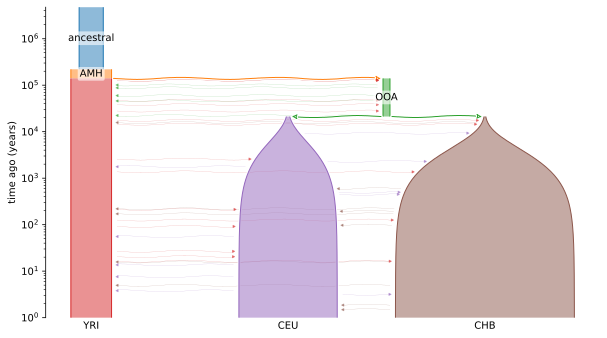

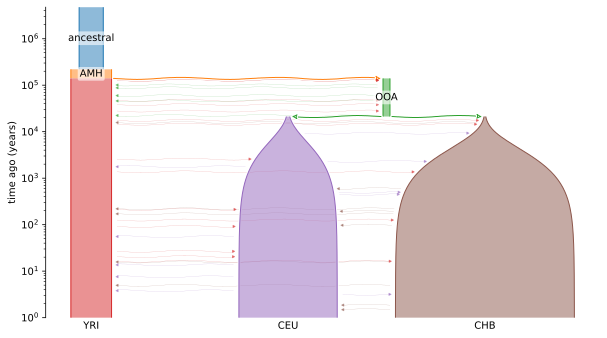

In [22]:
graph = demes.load(examples / "example_21.yaml")
w = 1.1 * size_max(graph)
positions = dict(ancestral=0, AMH=0, YRI=0, OOA=3*w/2, CEU=w, CHB=2*w)
ax = demesdraw.tubes(
    graph,
    positions=positions,
    seed=1,
    log_time=True,
    num_lines_per_migration=5
)
glue("example_21", ax.figure, display=False)

{{ example.replace("LABEL", "21") }}

## Selfing and cloning

Epochs also have `selfing_rate` and `cloning_rate` properties,
which default to 0 if not specified.

```{todo}
Give examples.
```